## FWI with Quasi-Newton methods from the NLopt library

In this notebook, we demonstrate how to interface the NLopt optimization library for full-waveform inversion with a limited-memory Quasi-Newton (L-BFGS) algorithm. Once again, we start by adding additional workers for parallel computing and by loading all necessary modules:

In [11]:
addprocs(4)
using SeisIO, HDF5, PyPlot, JUDI.TimeModeling

We load the FWI starting model from the HDF5 model file and set up the JUDI model structure:

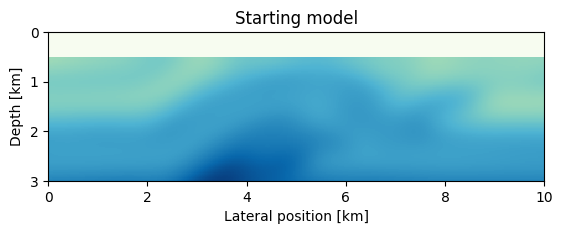

In [6]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

Then we read the SEG-Y file containing our test data set. The data was generated with a 2D excerpt from the Overthrust velocity model and consists of 31 shot records with 2 seconds recording time. We load the data and set up a JUDI seismic data vector:

In [7]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

Since the SEG-Y file contains the source coordinates, but not the wavelet itself, we create a JUDI `Geometry` structure for the source and then manually set up an 8 Hz Ricker wavelet. As for the observed data, we set up a JUDI seismic data vector `q` with the source geometry and wavelet:

In [ ]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);

## Optimization

Rather than implementing the L-BFGS algorithms in Julia ourselves, we interface the NLopt optimization library. This library requires objective functions with the current variable and gradient as input arguments and the function value as the only output argument. For this reason, we build a wrapper that is customized for the NLopt library around our `fwi_objective` function. The function `f!` takes a vectorized estimate of the current model as well as the (vectorized) gradient as input arguments. NLopt uses double precision for floating point variables, so the first step inside `f!` is to reshape and convert the model to single precision. Then we choose a randomized subset of sources and shot records and compute the function value `fval` and `gradient` of the FWI objective function. We then set the gradient in the water layer to zero and overwrite the input gradient `grad` with the new gradient. Furthermore, we keep track of the number of function evaluations through increasing the `count` variable, which will serve as the termination criterion for the algorithm. In Julia, we set up `f!` in the following way: 

In [12]:
batchsize = 8;
count = 0;

# NLopt objective function
println("No.  ", "fval         ", "norm(gradient)");
function f!(x,grad)

    # Update model
    model0.m = convert(Array{Float32,2}, reshape(x,model0.n))
   
    # Seclect batch and calculate gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])

    # Reset gradient in water column to zero
    gradient = reshape(gradient, model0.n); gradient[:,1:21] = 0f0
    grad[1:end] = vec(gradient)
          
    global count; count += 1
    println(count, "    ", fval, "    ", norm(grad))
    return convert(Float64,fval)
end

No.  fval         norm(gradient)


f! (generic function with 1 method)

As in our gradient descent and Gauss-Newton example, we define bound constraints for the squared slowness to prevent velocities from becoming negative or too large:

In [ ]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Convert to squared slowness
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

The NLopt library offers a range of different optimization algorithms, from which we choose the L-BFGS method. We create an optimization object called `opt` by specifying the algorithm we want to use and the dimenions of the unknown model vector. We then set the upper and lower bounds of the variable, define `f!` as the objective function and set the termination criterion to be a maximum of 15 function evaluations:

In [ ]:
opt = Opt(:LD_LBFGS, prod(model0.n));
lower_bounds!(opt, mmin); upper_bounds!(opt, mmax);
min_objective!(opt, f!);
maxeval!(opt,15);

Having set up the objective function, bound constraints and termination criterion, we can now run the inversion:

In [ ]:
(minf, minx, ret) = optimize(opt, vec(model0.m));

In [ ]:
imshow(sqrt.(1f0./reshape(minx, model0.n))', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with L-BFGS")
xlabel("Lateral position [km]");
ylabel("Depth [km]");